In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import utils
from utils import *
from __future__ import division, print_function

Using TensorFlow backend.


In [97]:
path = "data/weather/"
model_path = path + 'models/'
batch_size=64

In [4]:
data = pd.read_csv(path + 'all_data.csv', index_col='DateUTC', parse_dates=True, usecols=['DateUTC','TemperatureF','DewpointF','PressureIn','WindSpeedMPH','WindSpeedGustMPH','Humidity','HourlyPrecipIn','dailyrainin','SolarRadiationWatts/m^2'])
data.index = data.index.tz_localize('UTC').tz_convert('US/Pacific')
data.drop_duplicates(inplace=True)

data = data[data.TemperatureF > 0] # Remove bad temp
data = data[data.PressureIn   > 0] # Remove bad pressure
data = data[data.HourlyPrecipIn >= 0] # Remove bad rainfall

data = data.assign(forward_min = data.rolling('10h', closed='both').TemperatureF.min().shift(-1,'10h').asof(data.index))

data = data.assign(day_of_year = data.index.dayofyear, hour = data.index.hour)
data = data.assign(threshold = 'no')
data.loc[data.forward_min < 32,'threshold'] = '32'
data.loc[data.forward_min < 30,'threshold'] = '30'
data.loc[data.forward_min < 28,'threshold'] = '28'

data = data.merge(pd.get_dummies(data.threshold, prefix='threshold'), left_index=True, right_index=True)

data.head()

,TemperatureF,DewpointF,PressureIn,WindSpeedMPH,WindSpeedGustMPH,Humidity,HourlyPrecipIn,dailyrainin,SolarRadiationWatts/m^2,forward_min,day_of_year,hour,threshold,threshold_28,threshold_30,threshold_32,threshold_no
DateUTC,,,,,,,,,,,,,,,,,
2016-02-16 11:12:00-08:00,73.8,50.5,29.29,0.0,0.0,44,0.0,0.0,17.48,73.8,47,11,no,0,0,0,1
2016-02-16 11:14:00-08:00,74.5,50.5,29.29,0.0,0.0,43,0.0,0.0,17.48,73.8,47,11,no,0,0,0,1
2016-02-16 11:15:00-08:00,74.5,50.5,29.28,0.0,0.0,43,0.0,0.0,17.48,73.8,47,11,no,0,0,0,1
2016-02-16 11:16:00-08:00,74.5,50.5,29.27,0.0,0.0,43,0.0,0.0,17.53,73.8,47,11,no,0,0,0,1
2016-02-16 11:23:00-08:00,74.5,50.0,29.96,0.0,0.0,42,0.0,0.0,17.43,73.8,47,11,no,0,0,0,1


In [5]:
minutes_in_week = 60*24*7+30
seq_length=32
base = 30
multiple = np.exp(np.log(minutes_in_week/base)/(seq_length-1))
fp_fn_ratio=10
from pandas.tseries.offsets import *
offsets = pd.Series(DateOffset(minutes = base*(multiple**i-1)) for i in range(seq_length-1,-1,-1))
offsets
# wanted_cols = data[['TemperatureF','DewpointF','PressureIn','WindSpeedMPH','WindSpeedGustMPH','Humidity','HourlyPrecipIn','dailyrainin','SolarRadiationWatts/m^2','day_of_year', 'hour']]
# idx=wanted_cols.index[50000]
# %timeit wanted_cols.loc[([wanted_cols.index.asof(i) for i in (idx-offsets)])].values

0     <DateOffset: kwds={'minutes': 10079.99999999998}>
1     <DateOffset: kwds={'minutes': 8349.434435135774}>
2     <DateOffset: kwds={'minutes': 6915.09608830260...
3     <DateOffset: kwds={'minutes': 5726.27866643419...
4     <DateOffset: kwds={'minutes': 4740.95545754265...
5     <DateOffset: kwds={'minutes': 3924.29361517625...
6     <DateOffset: kwds={'minutes': 3247.42275822408...
7     <DateOffset: kwds={'minutes': 2686.41435398226...
8     <DateOffset: kwds={'minutes': 2221.43580394224...
9     <DateOffset: kwds={'minutes': 1836.04932779933...
10    <DateOffset: kwds={'minutes': 1516.630860041915}>
11    <DateOffset: kwds={'minutes': 1251.88841613045...
12    <DateOffset: kwds={'minutes': 1032.46290169388...
13    <DateOffset: kwds={'minutes': 850.5972526714213}>
14    <DateOffset: kwds={'minutes': 699.862209942718...
15     <DateOffset: kwds={'minutes': 574.929034114572}>
16    <DateOffset: kwds={'minutes': 471.381125546298...
17    <DateOffset: kwds={'minutes': 385.55789006

In [6]:
wanted_cols = data[['TemperatureF','DewpointF','PressureIn','WindSpeedMPH','WindSpeedGustMPH','Humidity','HourlyPrecipIn','dailyrainin','SolarRadiationWatts/m^2','day_of_year', 'hour']]

# TODO: This below takes 18 minutes to run on 124,028 data points.  Surely that could be faster??!?
# all_x = np.nan_to_num([wanted_cols.loc[([wanted_cols.index.asof(i) for i in (idx-offsets)])].values for idx in zip(wanted_cols.index)])
# all_y = data.threshold_32.values.reshape(-1,1)
# save_array(path+'all_x', all_x)
# save_array(path+'all_y', all_y)

all_x = load_array(path+'all_x')
all_y = load_array(path+'all_y')

all_x.shape, all_y.shape

((105241, 32, 11), (105241, 1))

In [87]:
train_idx = np.where(data.day_of_year%10!=3)
val_idx = np.where(data.day_of_year%10==3)

train_x, train_y = all_x[train_idx], all_y[train_idx]
val_x, val_y = all_x[val_idx], all_y[val_idx]

train_data = data.iloc[train_idx]
validation_data = data.iloc[val_idx]

In [88]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape, train_y.sum(), val_y.sum()

((94694, 32, 11), (94694, 1), (10547, 32, 11), (10547, 1), 2132, 248)

In [98]:
model = Sequential([
    BatchNormalization(input_shape=(seq_length, train_x.shape[2])),
    Dropout(0.25),
    
    Conv1D(64, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    BatchNormalization(),
    Conv1D(64, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    MaxPooling1D(),
    BatchNormalization(),

    Conv1D(128, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    BatchNormalization(),
    Conv1D(128, 3, padding='causal'),
    keras.layers.advanced_activations.PReLU(),
    MaxPooling1D(),
    BatchNormalization(),

#     Conv1D(256, 3, padding='causal'),
#     keras.layers.advanced_activations.PReLU(),
#     BatchNormalization(),
#     Conv1D(256, 3, padding='causal'),
#     keras.layers.advanced_activations.PReLU(),
#     MaxPooling1D(),
#     BatchNormalization(),

#     Conv1D(4, 3, padding='same', activation='relu'),
#     MaxPooling1D(),
#     BatchNormalization(),

#     Conv1D(512, 3, padding='same', activation='relu'),
#     BatchNormalization(),
#     Conv1D(512, 3, padding='same', activation='relu'),
#     BatchNormalization(),
#     MaxPooling1D(4),
    
    Flatten(),

    Dense(256),
    keras.layers.advanced_activations.PReLU(),
    BatchNormalization(),
    
    Dropout(0.75),
    Dense(train_y.shape[1], activation='sigmoid'),
])
model.compile(Nadam(), 'binary_crossentropy', ['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_101 (Bat (None, 32, 11)            44        
_________________________________________________________________
dropout_27 (Dropout)         (None, 32, 11)            0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 32, 64)            2176      
_________________________________________________________________
p_re_lu_88 (PReLU)           (None, 32, 64)            2048      
_________________________________________________________________
batch_normalization_102 (Bat (None, 32, 64)            256       
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 32, 64)            12352     
_________________________________________________________________
p_re_lu_89 (PReLU)           (None, 32, 64)            2048      
__________

Train on 94694 samples, validate on 10547 samples
Epoch 1/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.2963 - binary_accuracy: 0.9268

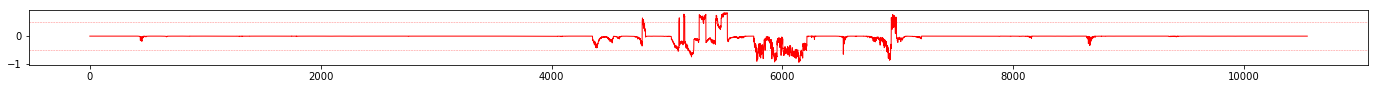

94694/94694 [==============================] - 40s - loss: 0.2960 - binary_accuracy: 0.9269 - val_loss: 0.0796 - val_binary_accuracy: 0.9553
Epoch 2/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.1437 - binary_accuracy: 0.9655

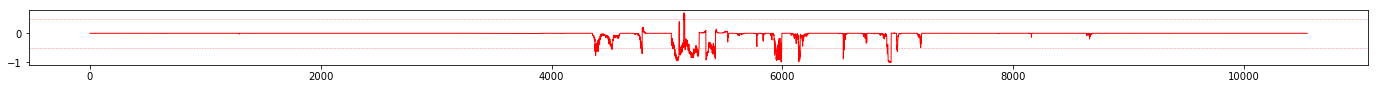

94694/94694 [==============================] - 35s - loss: 0.1437 - binary_accuracy: 0.9655 - val_loss: 0.0655 - val_binary_accuracy: 0.9695
Epoch 3/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.1129 - binary_accuracy: 0.9731

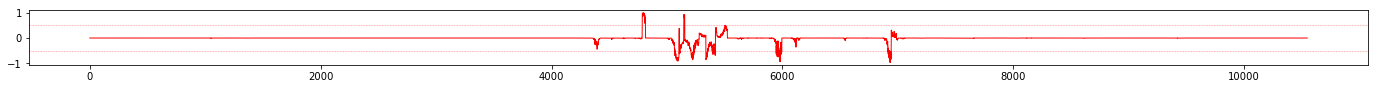

94694/94694 [==============================] - 35s - loss: 0.1128 - binary_accuracy: 0.9731 - val_loss: 0.0411 - val_binary_accuracy: 0.9821
Epoch 4/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.0883 - binary_accuracy: 0.9795

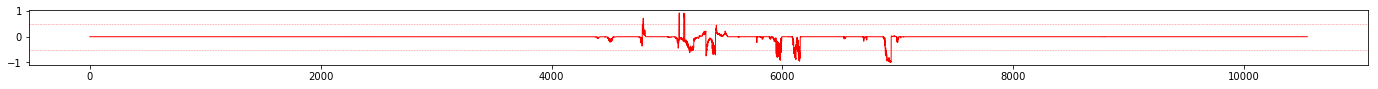

94694/94694 [==============================] - 35s - loss: 0.0883 - binary_accuracy: 0.9794 - val_loss: 0.0366 - val_binary_accuracy: 0.9855
Epoch 5/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.0844 - binary_accuracy: 0.9811

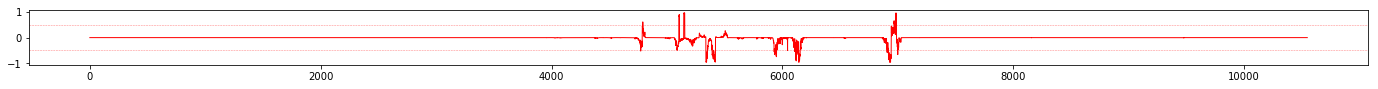

94694/94694 [==============================] - 35s - loss: 0.0844 - binary_accuracy: 0.9811 - val_loss: 0.0321 - val_binary_accuracy: 0.9876
Epoch 6/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0703 - binary_accuracy: 0.9842

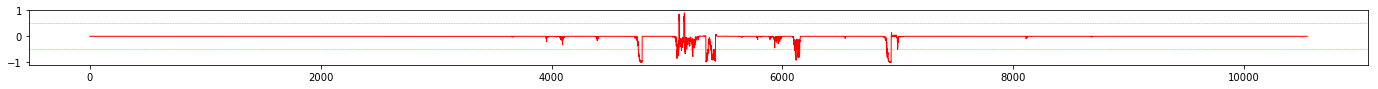

94694/94694 [==============================] - 35s - loss: 0.0703 - binary_accuracy: 0.9841 - val_loss: 0.0445 - val_binary_accuracy: 0.9827
Epoch 7/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.0661 - binary_accuracy: 0.9851- ETA: 2s - loss:

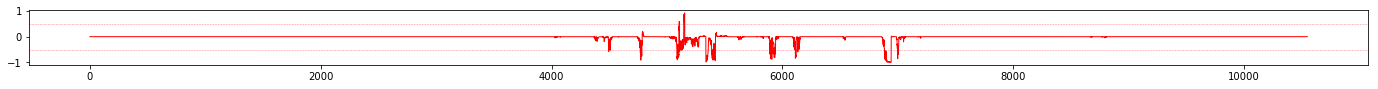

94694/94694 [==============================] - 36s - loss: 0.0661 - binary_accuracy: 0.9851 - val_loss: 0.0490 - val_binary_accuracy: 0.9820
Epoch 8/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.0592 - binary_accuracy: 0.9865

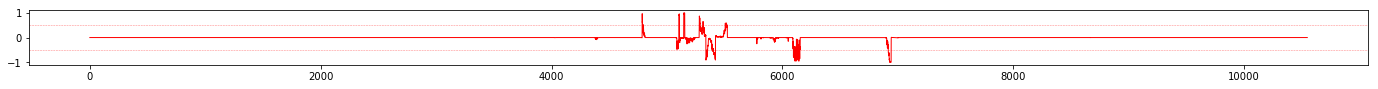

94694/94694 [==============================] - 35s - loss: 0.0592 - binary_accuracy: 0.9865 - val_loss: 0.0327 - val_binary_accuracy: 0.9871
Epoch 9/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0575 - binary_accuracy: 0.9874

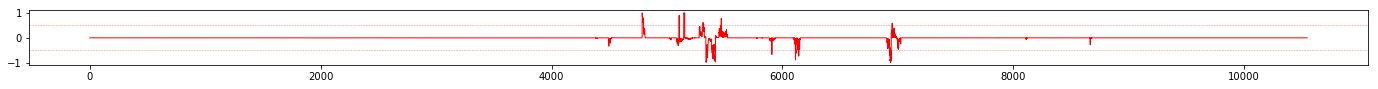

94694/94694 [==============================] - 35s - loss: 0.0575 - binary_accuracy: 0.9874 - val_loss: 0.0238 - val_binary_accuracy: 0.9920
Epoch 10/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.0525 - binary_accuracy: 0.9884

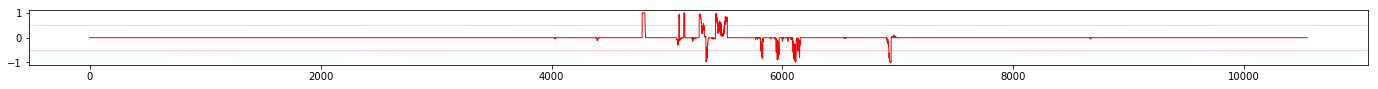

94694/94694 [==============================] - 35s - loss: 0.0525 - binary_accuracy: 0.9884 - val_loss: 0.0511 - val_binary_accuracy: 0.9824
Epoch 11/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.0509 - binary_accuracy: 0.9888

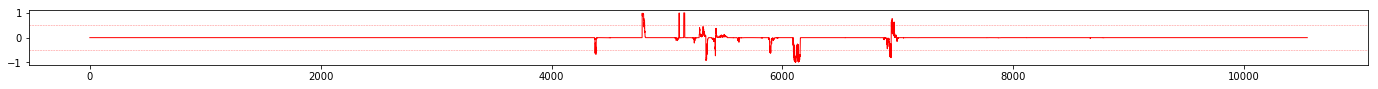

94694/94694 [==============================] - 35s - loss: 0.0509 - binary_accuracy: 0.9888 - val_loss: 0.0339 - val_binary_accuracy: 0.9887
Epoch 12/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0495 - binary_accuracy: 0.9894

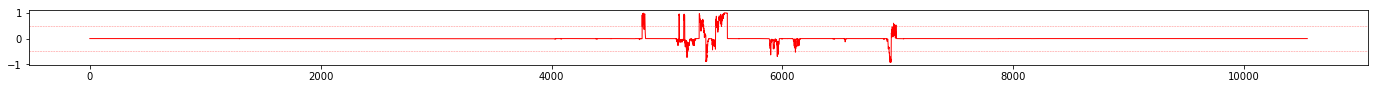

94694/94694 [==============================] - 35s - loss: 0.0495 - binary_accuracy: 0.9894 - val_loss: 0.0492 - val_binary_accuracy: 0.9816
Epoch 13/40
94592/94694 [============================>.] - ETA: 0s - loss: 0.0455 - binary_accuracy: 0.9900

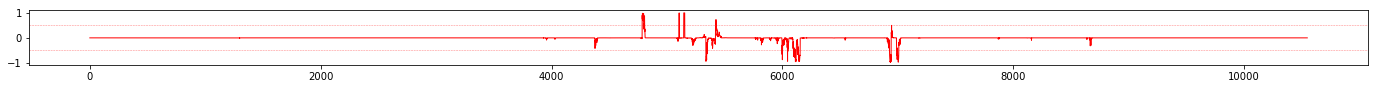

94694/94694 [==============================] - 35s - loss: 0.0455 - binary_accuracy: 0.9900 - val_loss: 0.0316 - val_binary_accuracy: 0.9886
Epoch 14/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.0447 - binary_accuracy: 0.9901

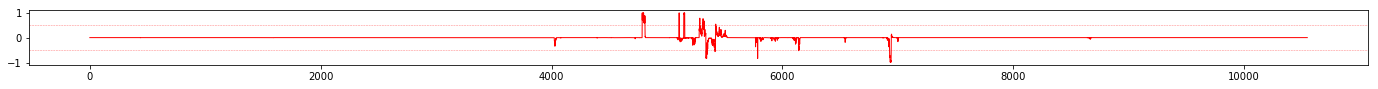

94694/94694 [==============================] - 35s - loss: 0.0447 - binary_accuracy: 0.9901 - val_loss: 0.0232 - val_binary_accuracy: 0.9928
Epoch 15/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0408 - binary_accuracy: 0.9910

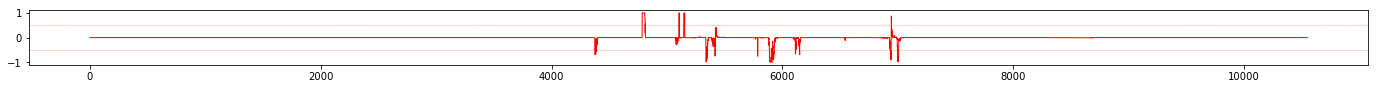

94694/94694 [==============================] - 35s - loss: 0.0408 - binary_accuracy: 0.9910 - val_loss: 0.0481 - val_binary_accuracy: 0.9885
Epoch 16/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0423 - binary_accuracy: 0.9913

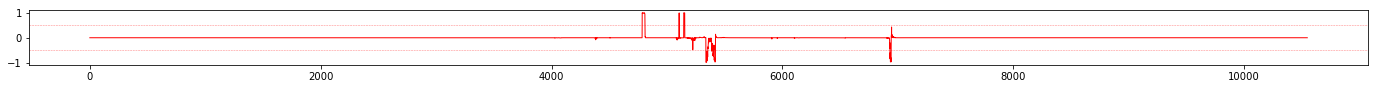

94694/94694 [==============================] - 35s - loss: 0.0423 - binary_accuracy: 0.9913 - val_loss: 0.0327 - val_binary_accuracy: 0.9919
Epoch 17/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0449 - binary_accuracy: 0.9906

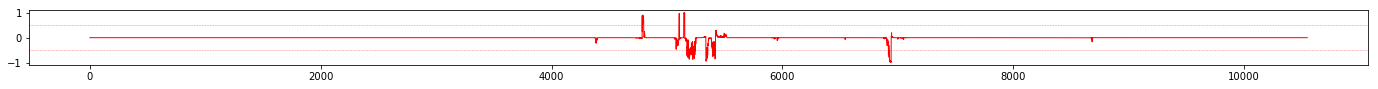

94694/94694 [==============================] - 35s - loss: 0.0448 - binary_accuracy: 0.9906 - val_loss: 0.0259 - val_binary_accuracy: 0.9885
Epoch 18/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.0389 - binary_accuracy: 0.9915

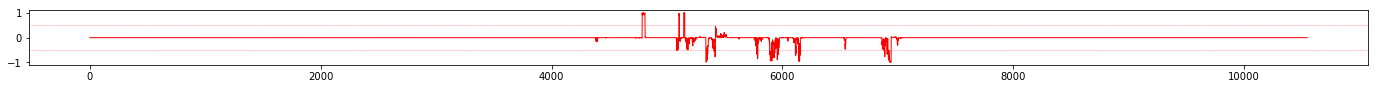

94694/94694 [==============================] - 35s - loss: 0.0389 - binary_accuracy: 0.9915 - val_loss: 0.0432 - val_binary_accuracy: 0.9863
Epoch 19/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.0386 - binary_accuracy: 0.9914
Epoch 00018: reducing learning rate to 0.0006000000284984708.


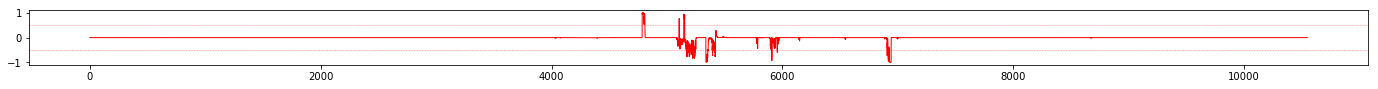

94694/94694 [==============================] - 36s - loss: 0.0386 - binary_accuracy: 0.9914 - val_loss: 0.0370 - val_binary_accuracy: 0.9885
Epoch 20/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0283 - binary_accuracy: 0.9933

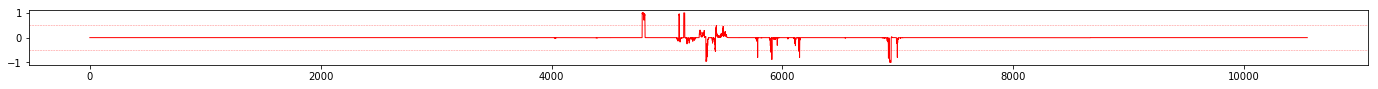

94694/94694 [==============================] - 35s - loss: 0.0284 - binary_accuracy: 0.9932 - val_loss: 0.0312 - val_binary_accuracy: 0.9928
Epoch 21/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0242 - binary_accuracy: 0.9946

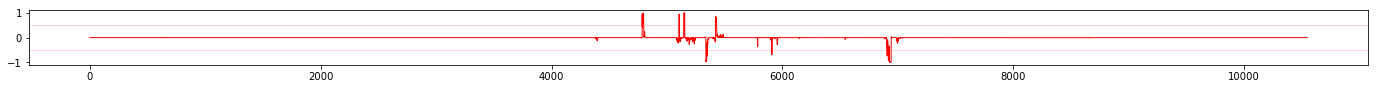

94694/94694 [==============================] - 35s - loss: 0.0243 - binary_accuracy: 0.9945 - val_loss: 0.0251 - val_binary_accuracy: 0.9930
Epoch 22/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0239 - binary_accuracy: 0.9945

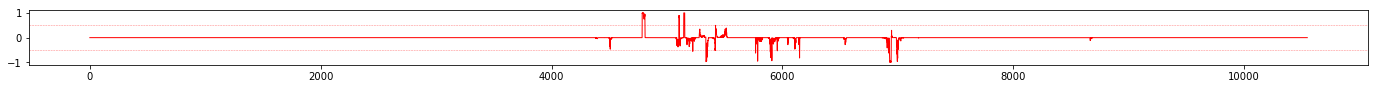

94694/94694 [==============================] - 35s - loss: 0.0240 - binary_accuracy: 0.9945 - val_loss: 0.0331 - val_binary_accuracy: 0.9913
Epoch 23/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.0236 - binary_accuracy: 0.9944

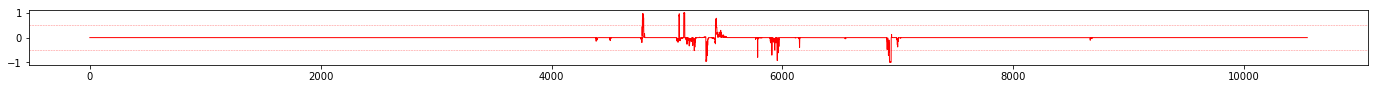

94694/94694 [==============================] - 35s - loss: 0.0236 - binary_accuracy: 0.9944 - val_loss: 0.0229 - val_binary_accuracy: 0.9935
Epoch 24/40
94592/94694 [============================>.] - ETA: 0s - loss: 0.0218 - binary_accuracy: 0.9948

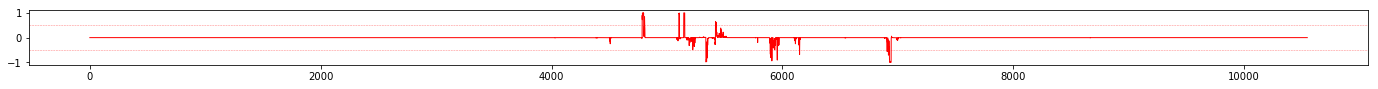

94694/94694 [==============================] - 35s - loss: 0.0217 - binary_accuracy: 0.9948 - val_loss: 0.0301 - val_binary_accuracy: 0.9927
Epoch 25/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.0221 - binary_accuracy: 0.9950

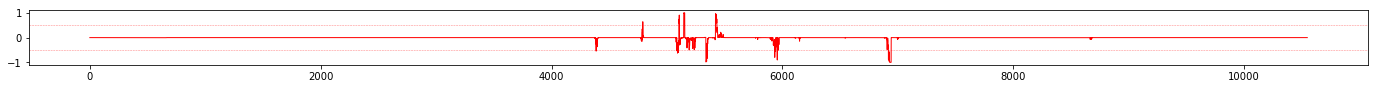

94694/94694 [==============================] - 35s - loss: 0.0221 - binary_accuracy: 0.9950 - val_loss: 0.0264 - val_binary_accuracy: 0.9930
Epoch 26/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.0206 - binary_accuracy: 0.9951

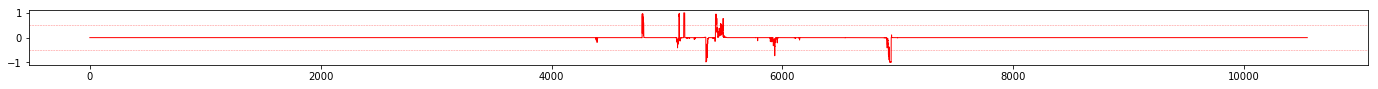

94694/94694 [==============================] - 35s - loss: 0.0206 - binary_accuracy: 0.9951 - val_loss: 0.0256 - val_binary_accuracy: 0.9932
Epoch 27/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0203 - binary_accuracy: 0.9953

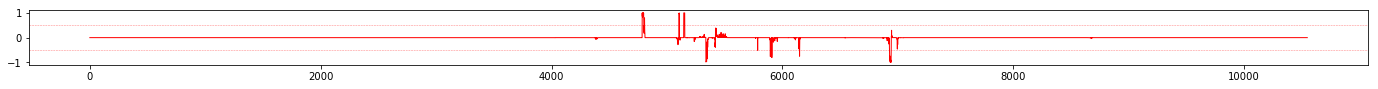

94694/94694 [==============================] - 35s - loss: 0.0203 - binary_accuracy: 0.9953 - val_loss: 0.0271 - val_binary_accuracy: 0.9941
Epoch 28/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.0189 - binary_accuracy: 0.9957
Epoch 00027: reducing learning rate to 0.00018000000854954124.


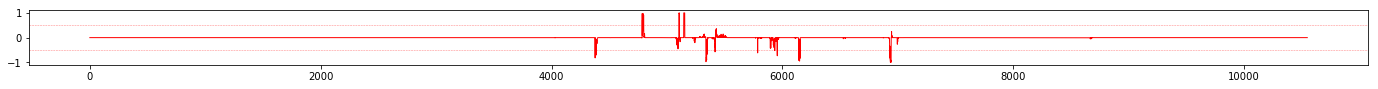

94694/94694 [==============================] - 35s - loss: 0.0189 - binary_accuracy: 0.9957 - val_loss: 0.0242 - val_binary_accuracy: 0.9943
Epoch 29/40
94592/94694 [============================>.] - ETA: 0s - loss: 0.0190 - binary_accuracy: 0.9956

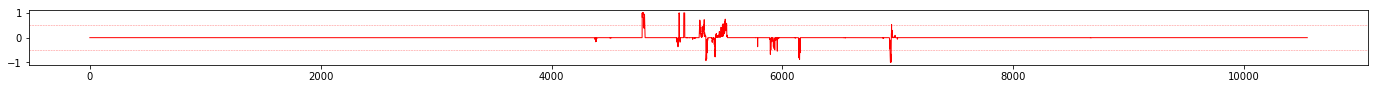

94694/94694 [==============================] - 35s - loss: 0.0190 - binary_accuracy: 0.9956 - val_loss: 0.0284 - val_binary_accuracy: 0.9924
Epoch 30/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.0171 - binary_accuracy: 0.9961

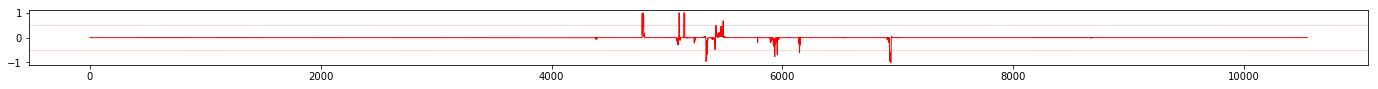

94694/94694 [==============================] - 35s - loss: 0.0171 - binary_accuracy: 0.9961 - val_loss: 0.0233 - val_binary_accuracy: 0.9952
Epoch 31/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0184 - binary_accuracy: 0.9960

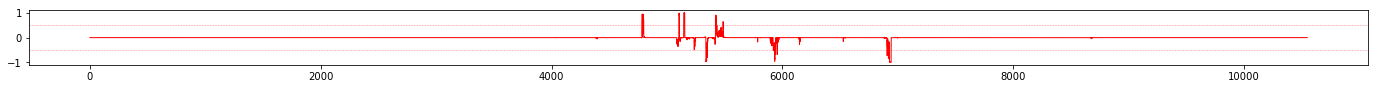

94694/94694 [==============================] - 35s - loss: 0.0183 - binary_accuracy: 0.9960 - val_loss: 0.0269 - val_binary_accuracy: 0.9927
Epoch 32/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.0168 - binary_accuracy: 0.9962- ETA: 0s - loss: 0.0169 - binary_accuracy: - ETA: 0s - loss: 0.0167 - binary_accuracy: 0.9
Epoch 00031: reducing learning rate to 5.400000081863254e-05.


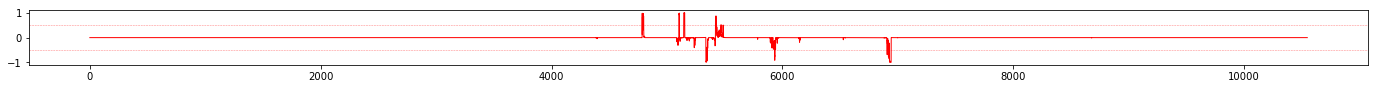

94694/94694 [==============================] - 35s - loss: 0.0168 - binary_accuracy: 0.9962 - val_loss: 0.0268 - val_binary_accuracy: 0.9933
Epoch 33/40
94656/94694 [============================>.] - ETA: 0s - loss: 0.0144 - binary_accuracy: 0.9966

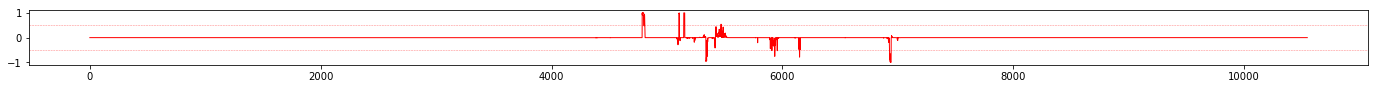

94694/94694 [==============================] - 34s - loss: 0.0144 - binary_accuracy: 0.9966 - val_loss: 0.0299 - val_binary_accuracy: 0.9936
Epoch 34/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0161 - binary_accuracy: 0.9964

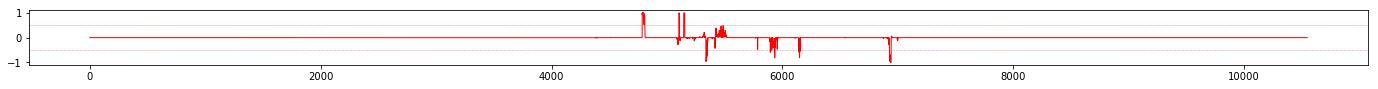

94694/94694 [==============================] - 35s - loss: 0.0160 - binary_accuracy: 0.9964 - val_loss: 0.0308 - val_binary_accuracy: 0.9934
Epoch 35/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0160 - binary_accuracy: 0.9963

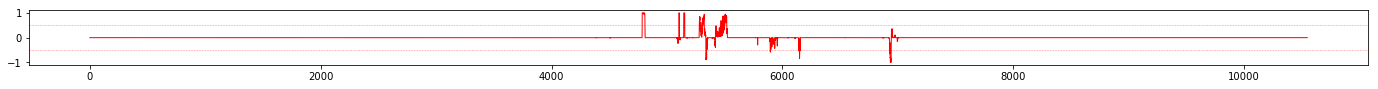

94694/94694 [==============================] - 35s - loss: 0.0160 - binary_accuracy: 0.9963 - val_loss: 0.0404 - val_binary_accuracy: 0.9891
Epoch 36/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0160 - binary_accuracy: 0.9964
Epoch 00035: reducing learning rate to 1.6200000027311033e-05.


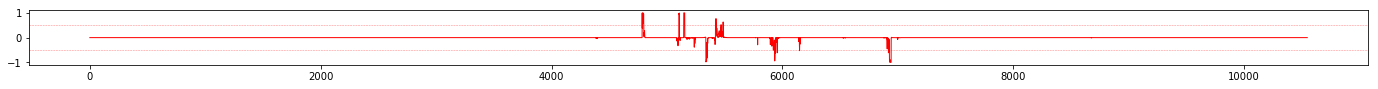

94694/94694 [==============================] - 35s - loss: 0.0160 - binary_accuracy: 0.9964 - val_loss: 0.0287 - val_binary_accuracy: 0.9930
Epoch 37/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0152 - binary_accuracy: 0.9963

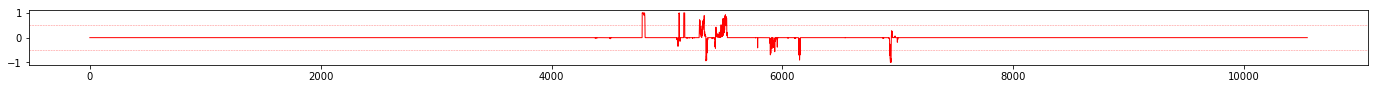

94694/94694 [==============================] - 35s - loss: 0.0152 - binary_accuracy: 0.9963 - val_loss: 0.0379 - val_binary_accuracy: 0.9901
Epoch 38/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0143 - binary_accuracy: 0.9965

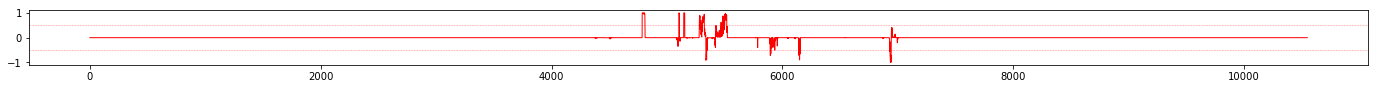

94694/94694 [==============================] - 35s - loss: 0.0143 - binary_accuracy: 0.9965 - val_loss: 0.0424 - val_binary_accuracy: 0.9883
Epoch 39/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0144 - binary_accuracy: 0.9967

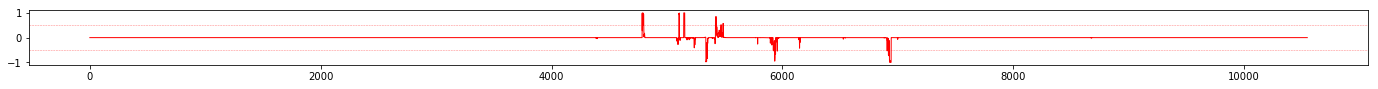

94694/94694 [==============================] - 35s - loss: 0.0144 - binary_accuracy: 0.9967 - val_loss: 0.0287 - val_binary_accuracy: 0.9926
Epoch 40/40
94528/94694 [============================>.] - ETA: 0s - loss: 0.0143 - binary_accuracy: 0.9966
Epoch 00039: reducing learning rate to 4.859999899053946e-06.


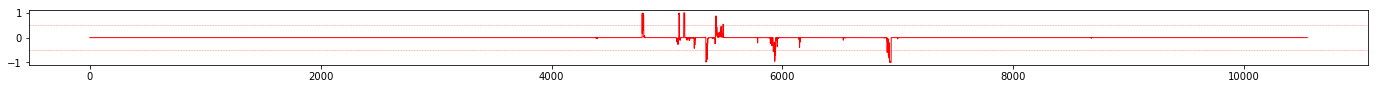

94694/94694 [==============================] - 35s - loss: 0.0143 - binary_accuracy: 0.9966 - val_loss: 0.0284 - val_binary_accuracy: 0.9928


In [99]:
class GraphCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
#         if epoch%2==1:
            plt.figure(figsize=(24,1))
            plt.plot((val_y-(model.predict(val_x, batch_size=batch_size))), 'r', lw=1)
            plt.axhline(0.5, color='r', ls='dashed', lw=0.5, alpha=0.5)
            plt.axhline(-0.5, color='r', ls='dashed', lw=0.5, alpha=0.5)
            plt.show()

reduce_lr = ReduceLROnPlateau(factor=0.3, patience=4, verbose=1)
graph_cb = GraphCallback()

history = model.fit(train_x, train_y,
          epochs=40,
          batch_size=batch_size,
          validation_data=(val_x, val_y),
          class_weight={0:1, 1:fp_fn_ratio, 2:fp_fn_ratio**2},
          callbacks=[reduce_lr, graph_cb])

dict_keys(['val_loss', 'lr', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


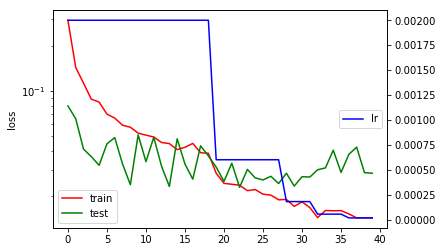

In [100]:
print(history.history.keys())
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_yscale('log')
ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='g')
ax1.set_ylabel('loss')
ax1.legend(['train', 'test'], loc='lower left')
ax2.plot(history.history['lr'], color='b')
ax2.legend(['lr'], loc='center right')
plt.xlabel('epoch')
plt.show()

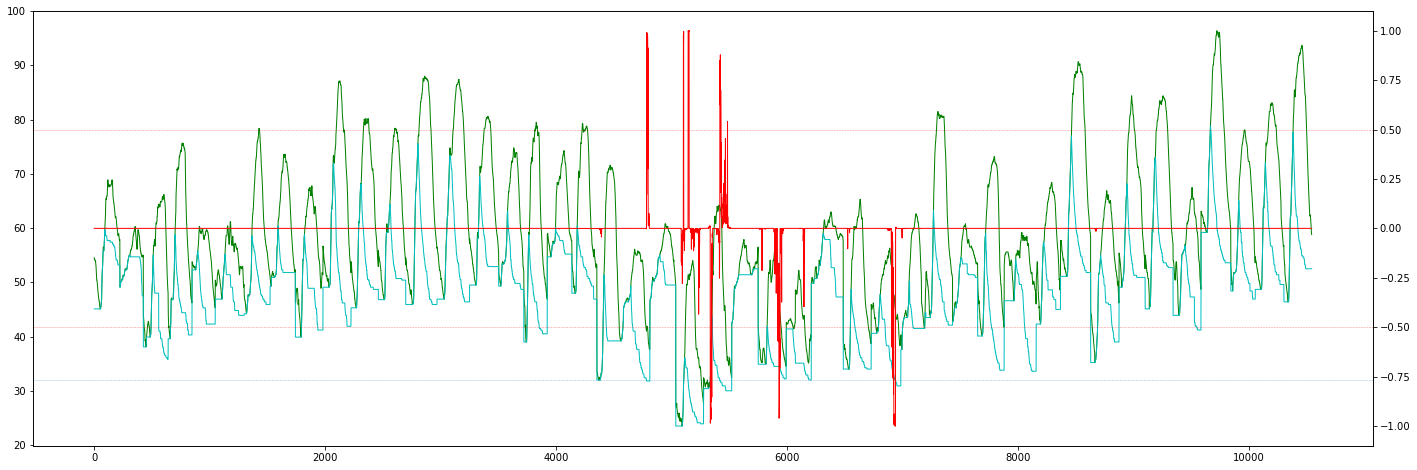

In [101]:
fig, ax1 = plt.subplots(figsize=(24,8))
ax2 = ax1.twinx()
ax1.plot(validation_data.TemperatureF.as_matrix(), 'g', lw=1)
ax1.plot(validation_data.forward_min.as_matrix(), 'c', lw=1)
ax2.plot(val_y-model.predict(val_x, batch_size=batch_size), 'r', lw=1)
ax2.axhline(0.5, color='r', ls='dashed', lw=0.5, alpha=0.5)
ax2.axhline(-0.5, color='r', ls='dashed', lw=0.5, alpha=0.5)

ax1.axhline(32, ls='dashed', lw=0.5, alpha=0.5)
plt.show()

In [102]:
prediction_data = validation_data.assign(prediction = np.round(model.predict(val_x, batch_size=batch_size)).astype(int))
prediction_data.index = prediction_data.index.tz_convert('UTC')
prediction_data = prediction_data.merge(pd.get_dummies(prediction_data.prediction, prefix='prediction'), left_index=True, right_index=True)
prediction_data = prediction_data.assign(fn = prediction_data.threshold_32*prediction_data.prediction_0)
prediction_data = prediction_data.assign(fp = prediction_data.threshold_no*prediction_data.prediction_1)

In [104]:
resample = '2H'
extract = prediction_data.TemperatureF.resample(resample).min().to_frame().merge(prediction_data.forward_min.resample(resample).min().to_frame(), left_index=True, right_index=True).merge(prediction_data.threshold_32.resample(resample).max().to_frame(), left_index=True, right_index=True).merge(prediction_data.prediction_1.resample(resample).max().to_frame(), left_index=True, right_index=True).merge(prediction_data.fn.resample(resample).prod().to_frame(), left_index=True, right_index=True).merge(prediction_data.fp.resample(resample).prod().to_frame(), left_index=True, right_index=True)
extract.fp = extract.fp * 32
extract.fn = extract.fn * 32
extract.fp[extract.fp==0] = float('nan')
extract.fn[extract.fn==0] = float('nan')
extract.fn.count(), extract.fp.count()

(0, 0)